In [1]:
from utils.helpers import MambaArgs, TrainingArgs, DefaultArgs, LanguageDatasetMaker
from model.mamba import Mamba 
from utils.trainer import MambaTrainer
from torch.utils.data import DataLoader
import pickle
import os
import math
import torch.nn as nn
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, AutoTokenizer

## Training example

In [2]:
with open("../../kaggle_song_lyrics_dataset/kaggle_song_lyrics_dataset.pkl", "rb") as f:
    seqs = pickle.load(f)

In [ ]:
# defining the model

L = 32
B = 8
D = 16
N = 8

device = 'cpu' # hehe 
mamba_args = MambaArgs(N, D, n_layers=3)
model = Mamba(mamba_args).to(mamba_args.device)

# defining the training protocol
default_train_args = DefaultArgs()
train_args = TrainingArgs(
    n_epochs=10, L=L, B=B, lr=5*1.5e-3, **default_train_args.lm_args, warmup_epochs=0)

datasets = LanguageDatasetMaker(seqs, mamba_args, train_args, total_dataset_frac=0.1,
                                train_split=0.5, val_split=0.5)

# creating datasets + trainer
train_loader = DataLoader(datasets.train_set, B, shuffle=True)
val_loader   = DataLoader(datasets.val_set, B, shuffle=False)

trainer = MambaTrainer(mamba_args, train_args, model)


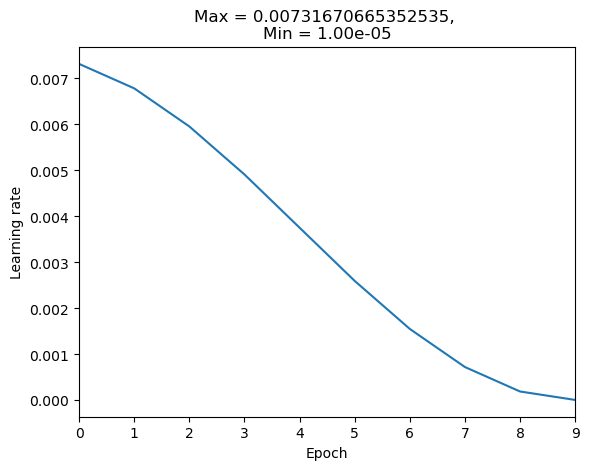

In [4]:
train_args.show_lr_schedule()

In [ ]:
trainer.train(train_loader, val_loader)

## Inference example

In [ ]:
# model = Mamba.from_pretrained('state-spaces/mamba-370m')

model = Mamba.from_pretrained('state-spaces/mamba-1.4b')
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neox-20b')


In [10]:
torch.manual_seed(5)
def generate(model,
             tokenizer,
             prompt: str,
             n_tokens_to_gen: int = 50,
             sample: bool = True,
             top_k: int = 40):
    model.eval()
    
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids
    
    for token_n in range(n_tokens_to_gen):
        with torch.no_grad():
            indices_to_input = input_ids
            next_token_logits = model(indices_to_input)[:, -1]
        
        probs = F.softmax(next_token_logits, dim=-1)
        (batch, vocab_size) = probs.shape
        
        if top_k is not None:
            (values, indices) = torch.topk(probs, k=top_k)
            probs[probs < values[:, -1, None]] = 0
            probs = probs / probs.sum(axis=1, keepdims=True)
        
        if sample:
            next_indices = torch.multinomial(probs, num_samples=1)
        else:
            next_indices = torch.argmax(probs, dim=-1)[:, None]
        
        input_ids = torch.cat([input_ids, next_indices], dim=1)

    output_completions = [tokenizer.decode(output.tolist()) for output in input_ids][0]
    
    return output_completions

In [14]:
# it actually works omg
print(generate(model, tokenizer, "def add(x, y): \n"))

def add(x, y): 
    return x + y

def subtract(x, y): 
    return x - y

def multiply(x,y): 
    return x * y

def divide(x, y): 
    r = x /
